<a href="https://colab.research.google.com/github/yaroslavtsepkov/colab/blob/lab_0/Lab_0_gpu_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPU INFO

In [102]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


# GPU INFO

In [103]:
!nvidia-smi

Mon Nov  2 04:38:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |    888MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Matrix multiplication


In [104]:
!pip install pycuda
!pip install scikit-cuda
import numpy as np
import cupy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt
from pycuda import driver, compiler, gpuarray, tools
import pycuda.autoinit
from pycuda.tools import make_default_context
import random
import skcuda.linalg as linalg
random.seed(0)

In [105]:
def genMatrix(n):
    return np.random.uniform(size=(n,n)).astype(np.float32)

# Перемножение матриц на CPU numpy.matmul

In [106]:
def cpuMult(size):
    time_cpu = []
    for n in size:
        matrix = genMatrix(n)
        s = time.time()
        np.matmul(matrix, matrix)
        p = time.time()
        time_cpu.append(p-s)
    return np.array(time_cpu)

# Перемножение матриц на GPU с cupy.matmul

In [107]:
def gpuMult(n):
    time_cupy = []
    for n in size:
        matrix = cp.array(genMatrix(n))
        s = time.time()
        cp.matmul(matrix, matrix)
        p = time.time()
        time_cupy.append(p-s)
    return np.array(time_cupy)

# Перемножение матриц на GPU pyCUDA

In [108]:
def gpuPyCuda(n):
    time_pycuda = []
    for n in size:
        matrix = genMatrix(n)
        matrix = gpuarray.to_gpu(matrix) 
        matrix_result = gpuarray.empty((n, n), np.float32)
        mod = compiler.SourceModule("""
__global__ void MatrixMulKernel(float *a, float *b, float *c)
{
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int idy = threadIdx.y + blockIdx.y * blockDim.y;
    float Pvalue = 0;

    for (int k = 0; k < %(MATRIX_SIZE)s; ++k) {
        Pvalue += a[idy * %(MATRIX_SIZE)s + k] * b[k * %(MATRIX_SIZE)s + idx];
    }
    c[idy * %(MATRIX_SIZE)s + idx] = Pvalue;
}
""" % {'MATRIX_SIZE': n} )
        matrixmul = mod.get_function("MatrixMulKernel")
        s = time.time()
        matrixmul(matrix, matrix, matrix_result, block = (32, 32, 1),)
        p = time.time()
        time_pycuda.append(p-s)
    return np.array(time_pycuda)

# Перемножение матриц на GPU skCUDA

In [109]:
def gpuSkCuda(n):
    time_pycuda = []
    for n in size:
        matrix = genMatrix(n)
        matrix = gpuarray.to_gpu(matrix) 
        s = time.time()
        linalg.mdot(matrix, matrix)
        p = time.time()
        time_pycuda.append(p-s)
    return np.array(time_pycuda)

# Вычисления

In [110]:
startSizeMatrix = 50
size = list(range(50, 2001, 50))

In [111]:
time_cpu = cpuMult(size)

In [112]:
time_cupy = gpuMult(size)

In [113]:
time_pycuda = gpuPyCuda(size)

In [114]:
linalg.init()
time_skcuda = gpuSkCuda(size)

# Анализ и визуализация

In [115]:
df = pd.DataFrame({
    'size_of_matrix': size_list_cpu,
    'time_for_CPU': time_cpu,
    'time_for_GPU_cupy': time_cupy,
    'time_for_GPU_pycuda': time_pycuda,
    'time_for_GPU_skcuda': time_skcuda,
    'boost cupy & cpu': time_cpu / time_cupy,
    'boost pycuda & cpu': time_cpu/ time_pycuda,
    'boost skcuda & cpu': time_cpu/ time_skcuda,
})
df.head()

,size_of_matrix,time_for_CPU,time_for_GPU_cupy,time_for_GPU_pycuda,time_for_GPU_skcuda,boost cupy & cpu,boost pycuda & cpu,boost skcuda & cpu
0,50,0.000174,0.001865,0.000168,0.000624,0.093454,1.035411,0.279221
1,100,0.009443,0.000057,0.000090,0.000193,165.719665,104.780423,48.837238
2,150,0.000166,0.000039,0.000080,0.000265,4.296296,2.077612,0.625899
3,200,0.000389,0.000060,0.000047,0.000246,6.501992,8.284264,1.581395
4,250,0.000707,0.000052,0.000044,0.000183,13.600917,16.027027,3.855657


In [116]:
df.to_csv(index=False)

'size_of_matrix,time_for_CPU,time_for_GPU_cupy,time_for_GPU_pycuda,time_for_GPU_skcuda,boost cupy & cpu,boost pycuda & cpu,boost skcuda & cpu\n50,0.0001742839813232422,0.0018649101257324219,0.00016832351684570312,0.0006241798400878906,0.0934543594988494,1.0354107648725213,0.2792207792207792\n100,0.009443044662475586,5.698204040527344e-05,9.012222290039062e-05,0.0001933574676513672,165.71966527196653,104.78042328042328,48.83723797780518\n150,0.0001659393310546875,3.8623809814453125e-05,7.987022399902344e-05,0.0002651214599609375,4.296296296296297,2.0776119402985076,0.6258992805755396\n200,0.00038909912109375,5.984306335449219e-05,4.696846008300781e-05,0.0002460479736328125,6.50199203187251,8.284263959390863,1.5813953488372092\n250,0.0007069110870361328,5.1975250244140625e-05,4.410743713378906e-05,0.00018334388732910156,13.600917431192661,16.027027027027028,3.8556566970091026\n300,0.0010745525360107422,6.079673767089844e-05,4.863739013671875e-05,0.0002560615539550781,17.67450980392157,22

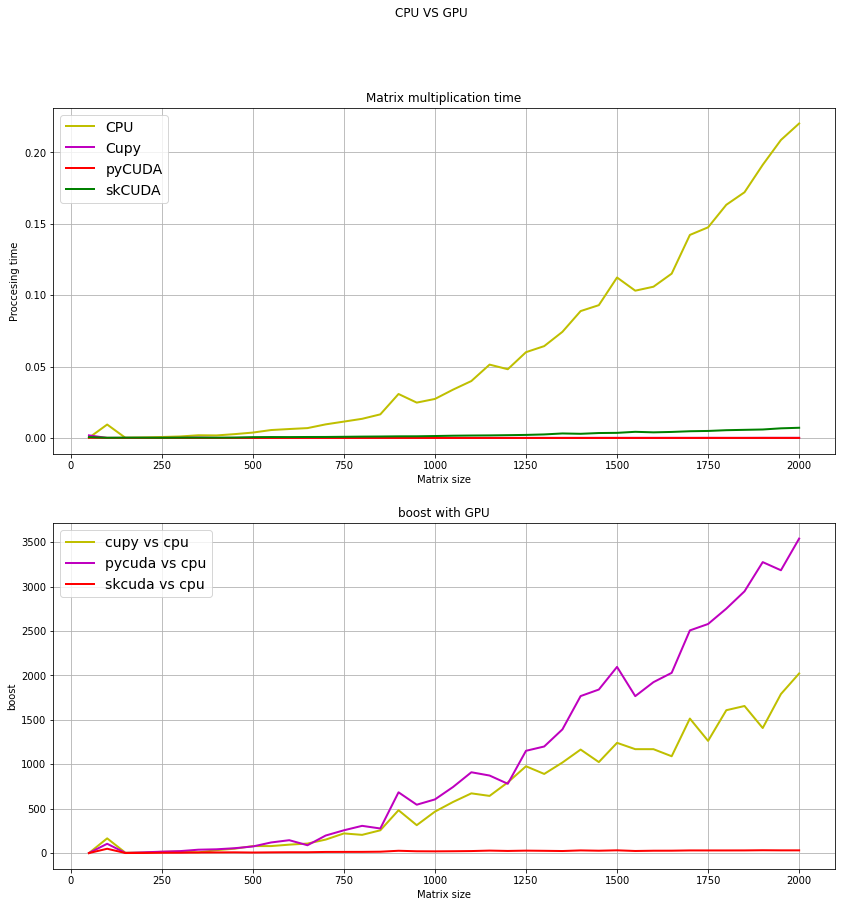

In [117]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14))
fig.suptitle('CPU VS GPU') 

ax1.plot(df.size_of_matrix, df.time_for_CPU, color='y', label = 'CPU', linewidth=2)
ax1.plot(df.size_of_matrix, df.time_for_GPU_cupy, color='m', label = 'Cupy', linewidth=2)
ax1.plot(df.size_of_matrix, df.time_for_GPU_pycuda, color='r', label = 'pyCUDA', linewidth=2)
ax1.plot(df.size_of_matrix, df.time_for_GPU_skcuda, color='g', label = 'skCUDA', linewidth=2)
ax1.legend(loc="upper left", fontsize=14)
ax1.set_xlabel('Matrix size')
ax1.set_ylabel('Proccesing time')
ax1.set_title('Matrix multiplication time')
ax1.grid()

ax2.plot(df.size_of_matrix, df['boost cupy & cpu'], label = 'cupy vs cpu', color='y', linewidth=2)
ax2.plot(df.size_of_matrix, df['boost pycuda & cpu'],label = 'pycuda vs cpu', color='m', linewidth=2)
ax2.plot(df.size_of_matrix, df['boost skcuda & cpu'],label = 'skcuda vs cpu', color='r', linewidth=2)
ax2.legend(loc="upper left", fontsize=14)
ax2.set_xlabel('Matrix size')
ax2.set_ylabel('boost')
ax2.set_title('boost with GPU')
ax2.grid()


plt.show()
fig.savefig('plot.svg')